In [ ]:
import cv2
from google.colab.patches import cv2_imshow

## **BERT input representation.**
###The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings

##**Input/Output Representations**



 



**Token embeddings**: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.


**Segment embedding**s: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.



**Positional embeddings**: A positional embedding is added to each token to indicate its position in the sentence.




Its input representation is constructed by summing the corresponding token segment, and position embeddings.

Our input representation is able to unambiguously represent both a single sentence and a pair of sentences in one token sequence.

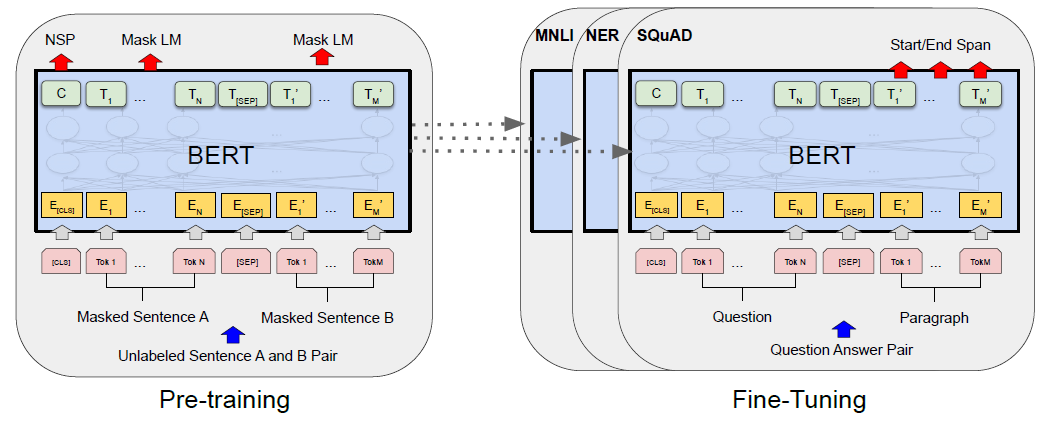

In [ ]:
img2= cv2.imread("input2.png")

cv2_imshow(img2)

##**Pre-training BERT**

####*TASK 1* : 

Masked LM:
1. In order to train a deep bidirectional representation, we simply mask some percentage of the input tokens at random, and then predict those masked tokens.
 

2. The training data generator chooses 15% of the token positions at random for
prediction. If the i-th token is chosen, we replace
the i-th token with 


(1) the [MASK] token 80% of
the time 


(2) a random token 10% of the time 


(3)the unchanged i-th token 10% of the time. 


We only predict the masked words rather than reconstructing the entire input.



###*TASK 2* :

Next Sentence Prediction:
1. It involves understanding the relationship between two sentences. 

2. When choosing the sentences A and B for each pretraining, for example, 50% of the time B is the actual next sentence that follows A (labeled as IsNext) and 50% of the time it is a random sentence from the corpus (labeled as NotNext.



##**Fine-Tuning Bert**

1. BERT uses the self-attention mechanism for encoding a concatenated text pair with self-attention which effectively includes bidirectional cross attention between two sentences.

**Cross-attention Algorithm**
1. Let us have embeddings (token) sequences S1 and S2
2. Calculate Key and Value from sequence S1
3. Calculate Queries from sequence S2
4. Calculate attention matrix from Keys and Queries
5. Apply queries to the attention matrix
Output sequence has dimension and length of sequence S2

###**Model Architecture**


1. BERT is a multi-layered encoder. 
2. There are two models: BERT base and BERT large. 


BERT base – 12 layers, 12 attention heads, and 110 million parameters.


BERT Large – 24 layers, 16 attention heads and, 340 million parameters 

In [ ]:
!pip install numpy==1.20.0
!pip install torch==1.0.1
!pip install spacy==2.1.3
!pip install pytorch-pretrained-bert==0.6.2
!pip install Cython==0.29.10
!pip install tqdm==4.32.2
!pip install neuralcoref==4.0
!pip install argparse
!pip install sklearn

     |████████████████████████████████| 15.3 MB 5.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 560.1 MB 21 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.0.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.0.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.0.1 which is incompatible.
     |████████████████████████████████| 27.7 MB 1.4 MB/s 
     |████████████████████████████████| 2.1 MB 42.7 MB/s 
     |████████████████████████████████| 82 kB 371 kB/s 
     |████████████████████████████████| 3.2 MB 38.8 MB/s 
  Attempting uninstall: preshed
    Found existing installation: preshed 3.0.6
    Uni

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
from numpy import ndarray
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from typing import List


class ClusterFeatures(object):

    def __init__(self, features: ndarray, algorithm: str='kmeans', pca_k: int=None):
        if pca_k:
            self.features = PCA(n_components=pca_k).fit_transform(features)
        else:
            self.features = features
        self.algorithm = algorithm
        self.pca_k = pca_k

    def __get_model(self, k: int):
        if self.algorithm == 'gmm':
            return GaussianMixture(n_components=k)
        return KMeans(n_clusters=k)

    def __get_centroids(self, model):
        if self.algorithm == 'gmm':
            return model.means_
        return model.cluster_centers_

    def __find_closest_args(self, centroids):
        centroid_min = 1e7
        cur_arg = -1
        args = {}
        used_idx = []
        for j, centroid in enumerate(centroids):
            for i, feature in enumerate(self.features):
                value = np.sum(np.abs(feature - centroid))
                if value < centroid_min and i not in used_idx:
                    cur_arg = i
                    centroid_min = value
            used_idx.append(cur_arg)
            args[j] = cur_arg
            centroid_min = 1e7
            cur_arg = -1
        return args

    # change ratios for following two functions to control summary length
    def cluster(self, ratio: float=0.13) -> List[int]:
        k = 1 if ratio * len(self.features) < 1 else int(len(self.features) * ratio)
        model = self.__get_model(k).fit(self.features)
        centroids = self.__get_centroids(model)
        cluster_args = self.__find_closest_args(centroids)
        sorted_values = sorted(cluster_args.values())
        return sorted_values

    def __call__(self, ratio: float=0.13) -> List[int]:
        return self.cluster(ratio)

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, GPT2Model, GPT2Tokenizer
import logging
import torch
import numpy as np
from tqdm import tqdm
from numpy import ndarray
from typing import List

logging.basicConfig(level=logging.WARNING)


class BertParent(object):

    def __init__(self, model: str, vector_size: int=None):
        self.model = BertModel.from_pretrained(model)
        self.tokenizer = BertTokenizer.from_pretrained(model)

        #the number of layers(i.e., Transformer blocks) as L
        #the hidden size as H
        #the number of self-attention heads as A

        #BERTBASE (L=12, H=768, A=12) 
        #BERTLARGE (L=24, H=1024, A=16)

        if model == 'bert-base-uncased':
            self.vector_size = 768
        elif model == 'bert-large-uncased':
            self.vector_size = 1024
        elif vector_size is None:
            raise RuntimeError("Vector size must be supplied for custom models")
        else:
            self.vector_size = vector_size

        self.model.eval()

    def tokenize_input(self, text: str) -> torch.tensor:
        tokenized_text = self.tokenizer.tokenize(text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        return torch.tensor([indexed_tokens])

    def extract_embeddings(self, text: str, hidden: int=-2, squeeze: bool=False, reduce_option: str ='mean') -> ndarray:
        tokens_tensor = self.tokenize_input(text)
        hidden_states, pooled = self.model(tokens_tensor)

        if hidden < -1 and hidden > -12:
            if reduce_option == 'max':
                pooled = hidden_states[hidden].max(dim=1)
            elif reduce_option == 'median':
                pooled = hidden_states[hidden].median(dim=1)
            else:
                pooled = hidden_states[hidden].mean(dim=1)

        if squeeze:
            return pooled.detach().numpy().squeeze()

        return pooled

    def create_matrix(self, content: List[str], hidden: int=-2, reduce_option: str = 'mean') -> ndarray:
        train_vec = np.zeros((len(content), self.vector_size))
        for i, t in tqdm(enumerate(content)):
            train_vec[i] = self.extract_embeddings(t, hidden=hidden, reduce_option=reduce_option).data.numpy()
        return train_vec

    def __call__(self, content: List[str], hidden: int=-2, reduce_option: str = 'mean') -> ndarray:
        return self.create_matrix(content, hidden, reduce_option)

In [ ]:
from typing import List
from abc import abstractmethod
import neuralcoref
from spacy.lang.en import English


class ModelProcessor(object):

    def __init__(self, model='bert-large-uncased',
                 vector_size: int = None,
                 hidden: int=-2,
                 reduce_option: str = 'mean',
                 greedyness: float=0.45):
        self.model = BertParent(model, vector_size)
        self.hidden = hidden
        self.vector_size = vector_size
        self.reduce_option = reduce_option
        self.nlp = English()
        self.nlp.add_pipe(self.nlp.create_pipe('sentencizer'))
        neuralcoref.add_to_pipe(self.nlp, greedyness=greedyness)

    def process_content_sentences(self, body: str, min_length=40, max_length=1000) -> List[str]:
        doc = self.nlp(body)._.coref_resolved
        doc = self.nlp(doc)
        return [c.string.strip() for c in doc.sents
                if len(c.string.strip()) > min_length and len(c.string.strip()) < max_length]

    #ratio for four functions below to specify size of summary 
    @abstractmethod
    def run_clusters(self, content: List[str], ratio=0.13, algorithm='kmeans', use_first: bool=True) -> List[str]:
        raise NotImplementedError("Must Implement run_clusters")

    def run(self, body: str, ratio: float=0.13, min_length: int=40, max_length: int=1000,
            use_first: bool=True, algorithm='kmeans') -> str:
        sentences = self.process_content_sentences(body, min_length, max_length)
        res = self.run_clusters(sentences, ratio, algorithm, use_first)
        return ' '.join(res)

    def __call__(self, body: str, ratio: float=0.13, min_length: int=40, max_length: int=1000,
                 use_first: bool=True, algorithm='kmeans') -> str:
        return self.run(body, ratio, min_length, max_length)


class SingleModel(ModelProcessor):

    def __init__(self, model='bert-large-uncased',
                 vector_size: int = None,
                 hidden: int=-2,
                 reduce_option: str = 'mean',
                 greedyness: float=0.45):
        super(SingleModel, self).__init__(model, vector_size, hidden, reduce_option, greedyness)

    def run_clusters(self, content: List[str], ratio=0.13, algorithm='kmeans', use_first: bool= True) -> List[str]:
        hidden = self.model(content, self.hidden, self.reduce_option)
        hidden_args = ClusterFeatures(hidden, algorithm).cluster(ratio)
        if use_first:
            if hidden_args[0] != 0:
                hidden_args.insert(0,0)
        return [content[j] for j in hidden_args]
        

100%|██████████| 40155833/40155833 [00:01<00:00, 25141578.27B/s]


In [ ]:
import numpy as np
#from summarizer import SingleModel
import bs4 as bs  
import urllib.request  
import re
import argparse
import nltk
import logging
import heapq


# choose BERT or vanilla summarizer
choose_bert_or_vanilla = input('Please enter 1 to use the BERT summarizer or 2 for the Vanilla summarizer:\n')

# BERT summarizer
if choose_bert_or_vanilla == '1':
    print('Welcome to the BERT Summarizer!\n')
    
    # choose URL, text file, or copy/paste input
    choose_summarizer = input('Enter A for URL input:\nEnter B for text file input:\nEnter C for copy/paste input:\n(case-sensitive)\n')

    if choose_summarizer == 'A':
        print('\nOption A processes and summarizes web articles.\nBest results are obtained by entering a URL of a text-centric website (e.g., Wikipedia, news sites, blogs.)\n')
        print("NB: A good rule of thumb... if your browser can display the webpage via its 'Reader View,' it's likely the summarizer is compatible with the site.")
        print("If not, feel free to start over and select one of the other two summary options; it's just as simple to use the Text Document Summarizer or the Copy/Paste Summarizer.\n")
        print("Either enter the URL of the page you'd like to summarize or feel free to copy/paste one of the URLs below to take the summarizer out for a spin:")
        print('https://en.wikipedia.org/wiki/Chernobyl_(miniseries)\nhttps://www.blog.google/products/assistant/more-information-about-our-processes-safeguard-speech-data\n')
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        # taking input from website article
        url = input('URL to summarize:\n')
        print('Summarizing...')

        # fetching and reading in data from URL
        scraped_data = urllib.request.urlopen(url)  
        article = scraped_data.read()

        # using beautifulsoup to parse article
        parsed_article = bs.BeautifulSoup(article,'lxml')
        paragraphs = parsed_article.find_all('p')

        # iterating and appending text to string
        article_text = ""

        for p in paragraphs:  
            article_text += p.text

        # model default params
        # use bert-base-uncased for smaller, less resource-intensive model
        model = SingleModel(
            model='bert-large-uncased',
            vector_size=None,
            hidden=-2,
            reduce_option='mean'
    )

        # passing in full text to model
        m = model(article_text)

        # creating final summary with a ratio of 0.13
        summary_file = '\n\nSUMMARY:\n' + m

        # printing summary and full text for comparison
        print(f'\nSUMMARY:\n{model(article_text)}\n')
        print(f'FULL TEXT:\n', article_text)
        
        # appending summary output to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)


    # text file summary option
    elif choose_summarizer == 'B':
        print('\nOption B summarizes text documents from Google Drive or your local machine.\n')
        print("\nSimply provide the path to the text document you'd like to summarize.\nOr feel free to copy/paste the filename of one of the sample documents below:\n")
        print('full_text/google_pixel_photobooth_article.txt')
        print('full_text/wash_post_youth_trending_away_from_news.txt\n')
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        document = input('Enter your <path/to/file.txt> here:\n')

        # reading in text file
        with open(document, 'r') as d:
            text_data = d.read()

        # importing model and passing in full text
        model = SingleModel()
        m = model(text_data)

        # creating final summary with a ratio of 0.13
        summary_file = '\n\nSUMMARY:\n' + m

        # printing summary and full text output for comparison
        print(f'\nSUMMARY:\n{model(text_data)}\n')
        print(f'FULL TEXT:\n', text_data)

        # appending summary output to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)


    # copy/paste string input option
    elif choose_summarizer == 'C':
        print("\nFor Option C, simply copy/paste any text you'd like to summarize below.\n\n")
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        text_copy_paste = input('INPUT:\n')
        text_copy_paste = 'Please wait while your summary is processing...'

        # importing model and passing in full-text string
        model = SingleModel()
        m = model(text_copy_paste)

        # creating final summary with a ratio of 0.13
        summary_file = '\n\nSUMMARY:\n' + m

        # printing summary and full text output for comparison
        print(f'\n\nSUMMARY:\n{model(text_copy_paste)}\n')
        print(f'FULL TEXT:\n', text_copy_paste)

        # appending summary output to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)

    else:
        print('\nMust choose from A, B, or C')


# baseline summarizer
if choose_bert_or_vanilla == '2':
    print('Welcome to the Baseline Model Summarizer!\n')

    # choose URL, text file, or string input
    choose_input = input('Enter A for URL input:\nEnter B for text file input:\nEnter C for copy/paste input:\n(case-sensitive)\n')

    if choose_input == 'A':
        print('\nOption A processes and summarizes web articles.\nBest results are obtained by entering a URL of a text-centric website (e.g., Wikipedia, news sites, blogs.)\n')
        print("NB: A good rule of thumb... if your browser can display the webpage via its 'Reader View,' it's likely the summarizer is compatible with the site.")
        print("If not, feel free to start over and select one of the other two summary options; it's just as simple to use the Text Document Summarizer or the Copy/Paste Summarizer.\n")
        print("Either enter the URL of the page you'd like to summarize or feel free to copy/paste one of the URLs below to take the summarizer out for a spin:")
        print('https://en.wikipedia.org/wiki/Chernobyl_(miniseries)\nhttps://www.blog.google/products/assistant/more-information-about-our-processes-safeguard-speech-data\n')
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        # enter URL
        url = input('URL to summarize: \n')
        print('Summarizing...')

        # fetching and reading in data from URL
        scraped_data = urllib.request.urlopen(url)  
        article = scraped_data.read()

        # using beautifulsoup to parse article
        parsed_article = bs.BeautifulSoup(article,'lxml')
        paragraphs = parsed_article.find_all('p')

        # iterating and appending to full-text string
        article_text = ""

        for p in paragraphs:  
            article_text += p.text

        # text clean up
        article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)  
        article_text = re.sub(r'\s+', ' ', article_text)  

        processed_article = re.sub('[^a-zA-Z]', ' ', article_text )  
        processed_article = re.sub(r'\s+', ' ', processed_article)

        # sentence-level tokenization of full text
        sentence_list = nltk.sent_tokenize(article_text)  

        # NLTK stopwords
        stopwords = nltk.corpus.stopwords.words('english')

        # creating term frequency dict
        word_frequencies = {}  
        for word in nltk.word_tokenize(processed_article):  
            if word not in stopwords:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

        maximum_frequency = max(word_frequencies.values())

        # adding term frequency ratio as dict values
        for word in word_frequencies.keys():  
            word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

        # ranking sentences for summary inclusion
        sentence_scores = {}  
        for sent in sentence_list:  
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
                    if len(sent.split(' ')) < 30:
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_frequencies[word]
                        else:
                            sentence_scores[sent] += word_frequencies[word]

        # creating final summary with default 4 highest-scoring sentences
        summary_sentences = heapq.nlargest(4, sentence_scores, key=sentence_scores.get)
        summary_sentences = ''.join(summary_sentences)
        summary_file = '\n\nSUMMARY:\n' + summary_sentences

        # printing summary and full text for comparison
        print(f'\nSUMMARY:\n{summary_sentences}\n\n')
        print(f'FULL TEXT:')
        print(article_text)

        # appending summary output to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)


    # text file input option
    elif choose_input == 'B':
        print('\nOption B summarizes text documents from Google Drive or your local machine.\n')
        print("\nSimply provide the path to the text document you'd like to summarize.\nOr feel free to copy/paste the filename of one of the sample documents below:\n")
        print('full_text/google_pixel_photobooth_article.txt')
        print('full_text/wash_post_youth_trending_away_from_news.txt\n')
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        document = input('Please enter your <path/to/file.txt> here:\n')

        # reading in text file
        with open(document, 'r') as d:
            text_data = d.read()

        # text clean up
        text_data = re.sub(r'\[[0-9]*\]', ' ', text_data)  
        text_data = re.sub(r'\s+', ' ', text_data)  

        processed_article = re.sub('[^a-zA-Z]', ' ', text_data )  
        processed_article = re.sub(r'\s+', ' ', processed_article)

        # sentence-level tokenization of full text
        sentence_list = nltk.sent_tokenize(text_data)  

        # NLTK stopword list
        stopwords = nltk.corpus.stopwords.words('english')

        # creating term frequency dict
        word_frequencies = {}  
        for word in nltk.word_tokenize(processed_article):  
            if word not in stopwords:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

        maximum_frequency = max(word_frequencies.values())

        # adding term frequency ratios as dict values
        for word in word_frequencies.keys():  
            word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

        # ranking sentences for summary inclusion
        sentence_scores = {}  
        for sent in sentence_list:  
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
                    if len(sent.split(' ')) < 30:
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_frequencies[word]
                        else:
                            sentence_scores[sent] += word_frequencies[word]

        # creating final summary with default 4 highest-scoring sentences
        summary_sentences = heapq.nlargest(4, sentence_scores, key=sentence_scores.get)
        summary_sentences = ''.join(summary_sentences)
        summary_file = '\n\nSUMMARY:\n' + summary_sentences

        # printing summary and full-text output for comparison
        print(f'\nSUMMARY:\n{summary_sentences}\n')
        print(f'FULL TEXT:')
        print(text_data)

        # appending summary to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)


    # copy/paste string input option
    elif choose_input == 'C':
        print("\nFor Option C, simply copy/paste any text you'd like to summarize below.\n\n")
        print("If you'd like a copy of your summary, you can find it in the `your_summaries` directory.\n")

        # reading in text as string
        text_copy_paste = input('INPUT:\n')
        text_copy_paste = str(text_copy_paste)

        # text processing and clean up
        text_copy_paste = re.sub(r'\[[0-9]*\]', ' ', text_copy_paste)  
        text_copy_paste = re.sub(r'\s+', ' ', text_copy_paste)  

        processed_article = re.sub('[^a-zA-Z]', ' ', text_copy_paste )  
        processed_article = re.sub(r'\s+', ' ', processed_article)

        # sentence-level tokenization of full text
        sentence_list = nltk.sent_tokenize(text_copy_paste)  

        # NLTK stopword list; optionally can use sklearn stopwords
        stopwords = nltk.corpus.stopwords.words('english')

        # creating term frequency dict
        word_frequencies = {}  
        for word in nltk.word_tokenize(processed_article):  
            if word not in stopwords:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

        maximum_frequency = max(word_frequencies.values())
        
        # adding term frequency ratios as dict values
        for word in word_frequencies.keys():  
            word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

        # final ranking for summary sentence inclusion
        sentence_scores = {}  
        for sent in sentence_list:  
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
                    if len(sent.split(' ')) < 30:
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_frequencies[word]
                        else:
                            sentence_scores[sent] += word_frequencies[word]

        # creating final summary with default 4 highest-scoring sentences
        summary_sentences = heapq.nlargest(4, sentence_scores, key=sentence_scores.get)
        summary_sentences = ''.join(summary_sentences)
        summary_file = '\n\nSUMMARY:\n' + summary_sentences

        # printing summary and full-text output for comparison
        print(f'\nSUMMARY:\n{summary_sentences}\n')
        print(f'FULL TEXT:')
        print(text_copy_paste)

        # appending summary to text file
        with open('your_summaries/summary.txt', 'a') as summary_output:
            for line in summary_file:
                summary_output.write(line)

    else:
        print('\nMust choose from A, B, or C')

Please enter 1 to use the BERT summarizer or 2 for the Vanilla summarizer:
1
Welcome to the BERT Summarizer!

Enter A for URL input:
Enter B for text file input:
Enter C for copy/paste input:
(case-sensitive)
A

Option A processes and summarizes web articles.
Best results are obtained by entering a URL of a text-centric website (e.g., Wikipedia, news sites, blogs.)

NB: A good rule of thumb... if your browser can display the webpage via its 'Reader View,' it's likely the summarizer is compatible with the site.
If not, feel free to start over and select one of the other two summary options; it's just as simple to use the Text Document Summarizer or the Copy/Paste Summarizer.

Either enter the URL of the page you'd like to summarize or feel free to copy/paste one of the URLs below to take the summarizer out for a spin:
https://en.wikipedia.org/wiki/Chernobyl_(miniseries)
https://www.blog.google/products/assistant/more-information-about-our-processes-safeguard-speech-data

If you'd like a

85it [01:15,  1.02s/it]
85it [01:12,  1.04it/s]



SUMMARY:
Vegetables are parts of plants that are consumed by humans or other animals as food. Nowadays, most vegetables are grown all over the world as climate permits, and crops may be cultivated in protected environments in less suitable locations. Vegetables can be eaten either raw or cooked and play an important role in human nutrition, being mostly low in fat and carbohydrates, but high in vitamins, minerals and dietary fiber. The word vegetable was first recorded in English in the early 15th century. Meat was a luxury but fish was more plentiful. The consumption of crunchy and hard to chew foods, such as raw vegetables, during youth, while the bones are still growing, is needed for the human's, and other animals', jaws' proper development, and without their consumption, the jaws don't grow to their full size, thus not leaving enough room for the teeth to grow in correctly, causing crooked and impacted teeth.[24][25]
However, vegetables often also contain toxins and antinutrients